In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr
import pandas as pd
import numpy as np
import re
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
train_data_dir = 'DATA/' 
test_data_dir = "TEST_DATA/"
tf.random.set_seed(123)

In [10]:
labels_csv = pd.read_csv('labels.csv')
print(labels_csv.head())
print(labels_csv.shape)

   ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)
(32, 2)


Visualization of RAW Images fom Kaggle

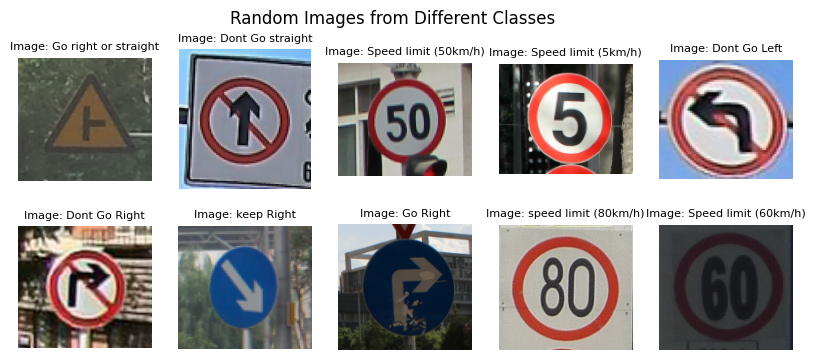

In [8]:
def plot_random_images(label_file, parent_folder):
    # Load the label file
    label_df = pd.read_csv(label_file)
    
    # Select 10 random labels
    labels = random.sample(label_df['ClassId'].tolist(), 10)
    
    # Initialize a list to hold the paths to the selected images and their labels
    image_data = []
    
    # Select one random image from each label folder
    for label in labels:
        # Get the corresponding string label from the CSV file
        string_label = label_df.loc[label_df['ClassId'] == label, 'Name'].iloc[0]
        
        # Construct the path to the label folder
        label_folder = os.path.join(parent_folder, str(label))
        
        # Get a list of all the image files in the label folder
        label_image_files = [os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith('.png')]
        
        # Select a random image from the list
        if label_image_files:
            random_image = random.choice(label_image_files)
            # Extract the label from the image file name
            image_label_match = re.findall(r'image(\d+)', random_image)
            if image_label_match:
                image_label = image_label_match[0]
            else:
                image_label = 'unknown'
            image_data.append((random_image, string_label, image_label))
    
    # Plot the selected images in a 2x5 grid with labels
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_data):
            image_path, label, image_label = image_data[i]
            image = plt.imread(image_path)
            ax.imshow(image)
            #ax.set_title(f'Image {image_label}: {label}')
            ax.set_title(f'Image: {label}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle('Random Images from Different Classes')
    plt.show()
    
label_file = 'labels.csv'
parent_folder = 'kaggle_data/DATA'

plot_random_images(label_file, parent_folder)

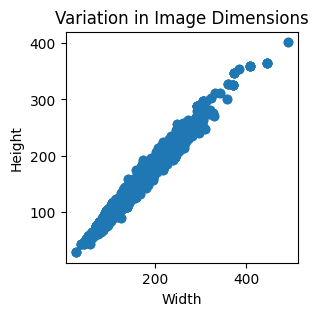

In [9]:
def plot_image_dimensions(parent_folder):
    # Initialize lists to hold the image dimensions
    heights = []
    widths = []

    # Loop through all the folders in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Get a list of all the image files in the folder
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

        # Loop through all the image files
        for image_file in image_files:
            # Load the image and get its dimensions
            image = plt.imread(image_file)
            height, width, _ = image.shape

            # Append the dimensions to the corresponding list
            heights.append(height)
            widths.append(width)

    # Create a scatter plot of the image dimensions
    plt.figure(figsize=(3, 3))
    plt.scatter(widths, heights)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Variation in Image Dimensions')
    plt.show()

parent_folder = 'kaggle_data/DATA'
plot_image_dimensions(parent_folder)

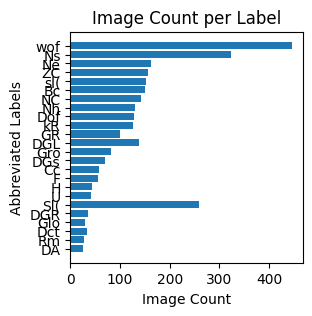

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def abbreviate_label(label, max_length=3):
    words = label.split()
    abbreviation = ''.join([word[0] for word in words])
    return abbreviation[:max_length]


def plot_image_count(parent_folder, csv_file):
    # Read the CSV file with folder names (integers) and corresponding labels
    df = pd.read_csv(csv_file)

    # Initialize an empty dictionary to store the count of images for each label
    image_count = {}

    # Loop through each row of the CSV and count the number of images in each folder
    for index, row in df.iterrows():
        folder_name = str(row['ClassId'])
        label = row['Name']
        folder_path = os.path.join(parent_folder, folder_name)

        # Count the number of images in the folder
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        # Store the count in the dictionary
        image_count[label] = image_count.get(label, 0) + num_images

    # Sort the dictionary by image count
    sorted_image_count = dict(sorted(image_count.items(), key=lambda item: item[1]))

    # Abbreviate labels
    abbreviated_labels = [abbreviate_label(label) for label in sorted_image_count.keys()]
	
    
    # Create a figure with a specified size (width, height) in inches
    plt.figure(figsize=(3, 3))
    
    # Plot the horizontal bar graph
    plt.barh(abbreviated_labels, list(sorted_image_count.values()))

    # Commented out to hide image count on each bar
    # for index, value in enumerate(sorted_image_count.values()):
    #     plt.text(value, index, f' {value}', fontsize=10)
    
    plt.xlabel('Image Count')
    plt.ylabel('Abbreviated Labels')
    plt.title('Image Count per Label')

    plt.show()

# Example usage
parent_folder = train_data_dir
parent_folder = 'kaggle_data/DATA'
csv_file = 'labels.csv'
plot_image_count(parent_folder, csv_file)

Data Augmentation - on raw images - Dont run already gave augmentated data

import os
import random
import shutil
import pandas as pd
import imgaug.augmenters as iaa
import cv2

def balance_image_count(parent_folder, csv_file):
    # Read the CSV file with folder names (integers) and corresponding labels
    df = pd.read_csv(csv_file)

    target_image_count = 100

    # Define the augmentation pipeline using imgaug
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.GaussianBlur(sigma=(0, 0.5)),
    ])

    # Loop through each row of the CSV
    for index, row in df.iterrows():
        folder_name = str(row['ClassId'])
        folder_path = os.path.join(parent_folder, folder_name)

        # Count the number of images in the folder
        image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        num_images = len(image_files)

        # If there are fewer images than the target, apply augmentation
        if num_images < target_image_count:
            for _ in range(target_image_count - num_images):
                # Randomly choose an image to augment
                img_file = random.choice(image_files)
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)

                # Apply the augmentation
                augmented_img = seq(image=img)

                # Save the augmented image
                augmented_img_file = f"{os.path.splitext(img_file)[0]}_augmented_{random.randint(1, 10000)}{os.path.splitext(img_file)[1]}"
                augmented_img_path = os.path.join(folder_path, augmented_img_file)
                cv2.imwrite(augmented_img_path, augmented_img)

        # If there are more images than the target, delete extra images randomly
        elif num_images > target_image_count:
            extra_images = random.sample(image_files, num_images - target_image_count)
            for img in extra_images:
                os.remove(os.path.join(folder_path, img))

parent_folder = train_data_dir
csv_file = 'labels.csv'
balance_image_count(parent_folder, csv_file)

Visualization on Augmentated Data

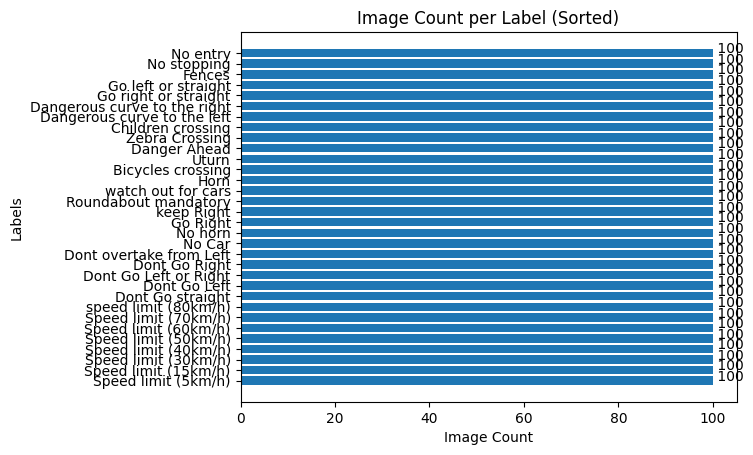

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_image_count(parent_folder, csv_file):
    # Read the CSV file with folder names (integers) and corresponding labels
    df = pd.read_csv(csv_file)

    # Initialize an empty dictionary to store the count of images for each label
    image_count = {}

    # Loop through each row of the CSV and count the number of images in each folder
    for index, row in df.iterrows():
        folder_name = str(row['ClassId'])
        label = row['Name']
        folder_path = os.path.join(parent_folder, folder_name)

        # Count the number of images in the folder
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        # Store the count in the dictionary
        image_count[label] = image_count.get(label, 0) + num_images

   # Sort the dictionary by image count
    sorted_image_count = dict(sorted(image_count.items(), key=lambda item: item[1]))

    # Plot the horizontal bar graph
    plt.barh(list(sorted_image_count.keys()), list(sorted_image_count.values()))

    # Display the actual image count on each bar
    for index, value in enumerate(sorted_image_count.values()):
        plt.text(value, index, f' {value}', fontsize=10)

    plt.xlabel('Image Count')
    plt.ylabel('Labels')
    plt.title('Image Count per Label (Sorted)')

    plt.show()

# Example usage
parent_folder = train_data_dir
csv_file = 'labels.csv'
plot_image_count(parent_folder, csv_file)


Labels of Classes

image_dataset_from_directory function. Generates a tf. data. Dataset from image files in a directory.

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(30,30),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=123
)

Found 3200 images belonging to 32 classes.


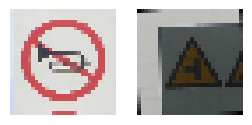

In [13]:
# Get the first batch of images
images, _ = next(train_generator)

# Plot the first 10 images in a 2x5 grid
fig, axes = plt.subplots(1, 2, figsize=(3, 3))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")

plt.show()

In [14]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(30,30),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=123
)

Found 1708 images belonging to 32 classes.


In [45]:
model_3 = Sequential()
model_3.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(30, 30, 3)))
model_3.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.25))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.25))
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(32, activation='softmax'))
#Compilation of the model
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 26, 26, 32)        2432      
                                                                 
 conv2d_52 (Conv2D)          (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 conv2d_54 (Conv2D)          (None, 7, 7, 64)          36928     
                                                     

In [47]:
# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint("models/best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")

In [48]:
history_3 = model_3.fit(train_generator,
                     epochs=30,
                     steps_per_epoch=len(train_generator),
                     validation_data= test_generator,
                     validation_steps=len(test_generator),
                     callbacks=[checkpoint])

Epoch 1/30
100/100 [==============================] - 10s 91ms/step - loss: 3.0984 - accuracy: 0.0944 - val_loss: 2.6987 - val_accuracy: 0.1417
Epoch 2/30
100/100 [==============================] - 9s 88ms/step - loss: 2.0090 - accuracy: 0.3416 - val_loss: 1.6163 - val_accuracy: 0.4625
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 1.2045 - accuracy: 0.5984 - val_loss: 1.5789 - val_accuracy: 0.4988
Epoch 4/30
100/100 [==============================] - 9s 89ms/step - loss: 0.8930 - accuracy: 0.6938 - val_loss: 1.3692 - val_accuracy: 0.6030
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6563 - accuracy: 0.7816 - val_loss: 1.6129 - val_accuracy: 0.5913
Epoch 6/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5794 - accuracy: 0.8050 - val_loss: 1.2074 - val_accuracy: 0.6733
Epoch 7/30
100/100 [==============================] - 9s 88ms/step - loss: 0.4648 - accuracy: 0.8487 - val_loss: 1.3209 - val_accuracy: 0.680

In [49]:
# Get the true class labels
y_true = test_generator.classes

# Make predictions using your trained model
predictions = model_3.predict(test_generator, verbose=1)

# Get the predicted class labels
y_pred = np.argmax(predictions, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Load the labels.csv file
labels = pd.read_csv('labels.csv')
class_names = labels['Name'].values.tolist()
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
df_cm = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)

54/54 [==============================] - 2s 31ms/step


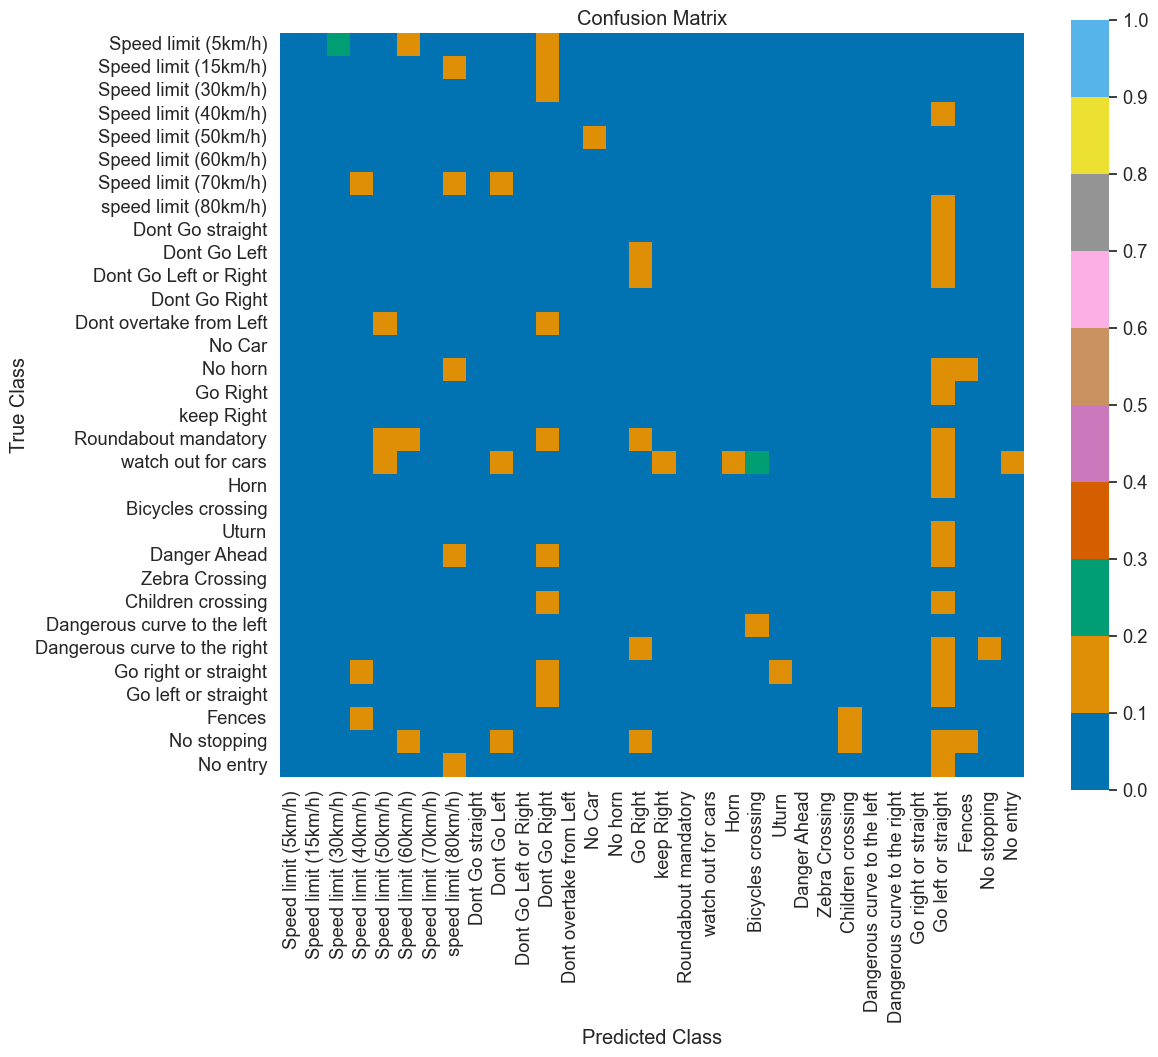

In [50]:
# Define the color scheme
cmap = sns.color_palette('colorblind', as_cmap=True)

# Create the clustered heatmap with color bar
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap=cmap, cbar=True, square=True, annot=False, yticklabels=True, xticklabels=True, vmin=0, vmax=1, cbar_kws={"orientation": "vertical", "ticks": np.linspace(0, 1, 11)})
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

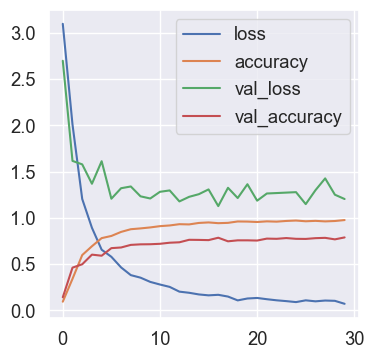

In [51]:
pd.DataFrame(history_3.history).plot(figsize=(4,4));

In [3]:
loaded_model = load_model("models/best_model.h5")

In [93]:
def preprocess_image(img_path, target_size=(30, 30)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Scaling the image (assuming your train_datagen also had rescale=1./255)
    return img_array

In [94]:
def plot_image_from_array(img_array):
    img = image.array_to_img(img_array[0])
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [119]:
new_image_path = "test1.png"
preprocessed_image = preprocess_image(new_image_path)

predictions = loaded_model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 29ms/step


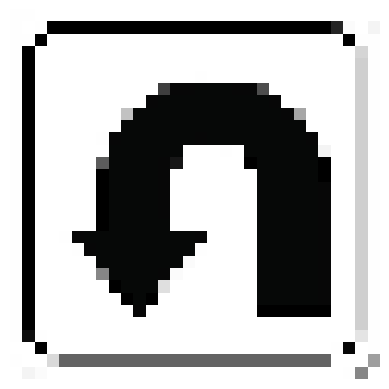

In [120]:
plot_image_from_array(preprocessed_image)

In [121]:
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_label = class_labels[predicted_class_index[0]]

In [122]:
def get_label_from_index(index, labels_df):
    label_row = labels_df.loc[labels_df["ClassId"] == int(index)]
    return label_row["Name"]

In [123]:
label = get_label_from_index(predicted_class_label, labels_csv)

In [124]:
label.iloc[0]

'Uturn'